### SuboptimumG Tutorial
 
This notebook will showcase how to use the key features of SuboptimumG. Note that if you ever modify the source code of the package. You have to **restart the kernel** so that your changes are detected! (Hit the "Restart" button on VSCode). Alternatively, you can also try to uncomment the cell below and run it.

In [1]:
# Make sure to run this cell first
# import subprocess
# import sys


# def run_pip_command(cmd, show_lines=2, show_start=False):
#     """Run pip command and show limited output lines"""
#     result = subprocess.run(cmd, capture_output=True, text=True)
#     output_lines = result.stdout.strip().split("\n")
#     if show_start:
#         output = "\n".join(
#             output_lines[:show_lines] + ["..."] + output_lines[-show_lines:]
#         )
#     else:
#         output = "\n".join(output_lines[-show_lines:])
#     print(output)


# # Install requirements (showing last 2 lines)
# run_pip_command([sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"])

# # Install package in editable mode (showing first 2 and last 2 lines)
# run_pip_command([sys.executable, "-m", "pip", "install", "-e", ".."], show_start=True)

#### Simulating a Single Competition

We start by simulating the results of a single competition with the default car (REV 9). We load in competition-wide parameters (tracks, competitor statistics, simulation hyperparameters, etc.) from competition.yaml. We load in car-specific parameters from car.yaml. Check these yaml files to see what SuboptimumG currently takes into account and to edit the defaults.

Observe that there are soft plausibility warnings when a parameter is outside of an expected range.

In [2]:
import suboptimumg
import yaml

# Uncomment this function to update sheets.yaml with the latest values on Google Drive.
suboptimumg.sheet_to_yaml.grab_sheet_data()
with open("../parameters/sheet.yaml", "r") as file:
    sheets_config = yaml.safe_load(file)

# Create sample competition
with open("../parameters/competition.yaml", "r") as file:
    comp_config = yaml.safe_load(file)

# Change this value to sheets.yaml if you would like to use Google Drive values
# NOTE: Those numbers are less verified, could cause unexpected crashes!
with open("../parameters/car.yaml", "r") as file:
    car_config = yaml.safe_load(file)

michigan2023_rev9 = suboptimumg.compsim.Competition.from_config(
    comp_config=comp_config, car_config=car_config
)

We run the competition by calling .run() on the competition object. Then, we can print out our point totals and graph some more detailed information, in this case power v.s. time during the Accel event.

Accel time: 4.055     Accel points: 70.8      
SkidP time: 5.401     SkidP points: 34.7      
AutoX time: 52.955    AutoX points: 77.2      
Endur time: 1495.2    Endur points: 229.5     Effcy points: 42.2      
                      Total points: 454.3     


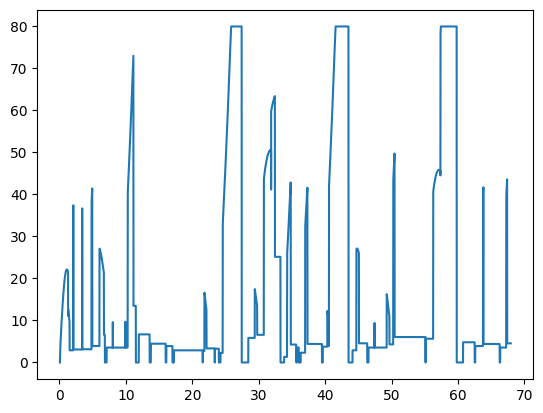

Power Statistics:
Max Power: 80.00000000000001 kW
Min Power: -0.0 kW
Avg Power: 23.157785094396672 kW


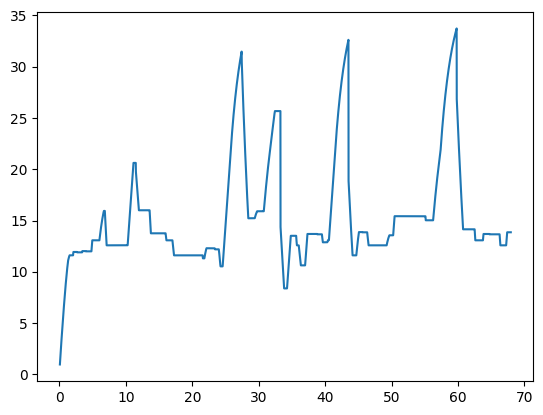

In [3]:
import matplotlib.pyplot as plt
from suboptimumg.plotting.utils import pretty_print_results

# Run sample competition
accel_results, skidpad_results, autoX_results, endurance_results, efficiency_points = (
    michigan2023_rev9.run()
)
pretty_print_results(
    accel_results, skidpad_results, autoX_results, endurance_results, efficiency_points
)

plt.plot(
    endurance_results.time_list, endurance_results.power_list / 1000, label="Power (kW)"
)
plt.show()

print("Power Statistics:")
print(f"Max Power: {max(endurance_results.power_list) / 1000} kW")
print(f"Min Power: {min(endurance_results.power_list) / 1000} kW")
print(
    f"Avg Power: {sum(endurance_results.power_list) / len(endurance_results.power_list) / 1000} kW"
)

plt.plot(endurance_results.time_list, endurance_results.vel_list)
plt.show()

We can also use custom functions to visualize the tracks that were used as part of the simulation. map_color and map_3d are function built on top of track_vis that map a second variable onto the track, to show the simulated instantaneous velocity and power consumption of the car at every point.

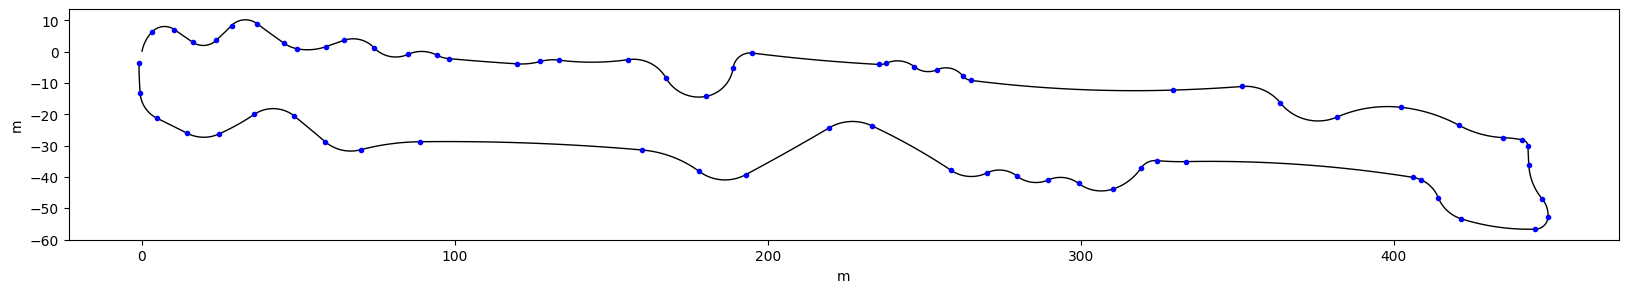

<Figure size 640x480 with 0 Axes>

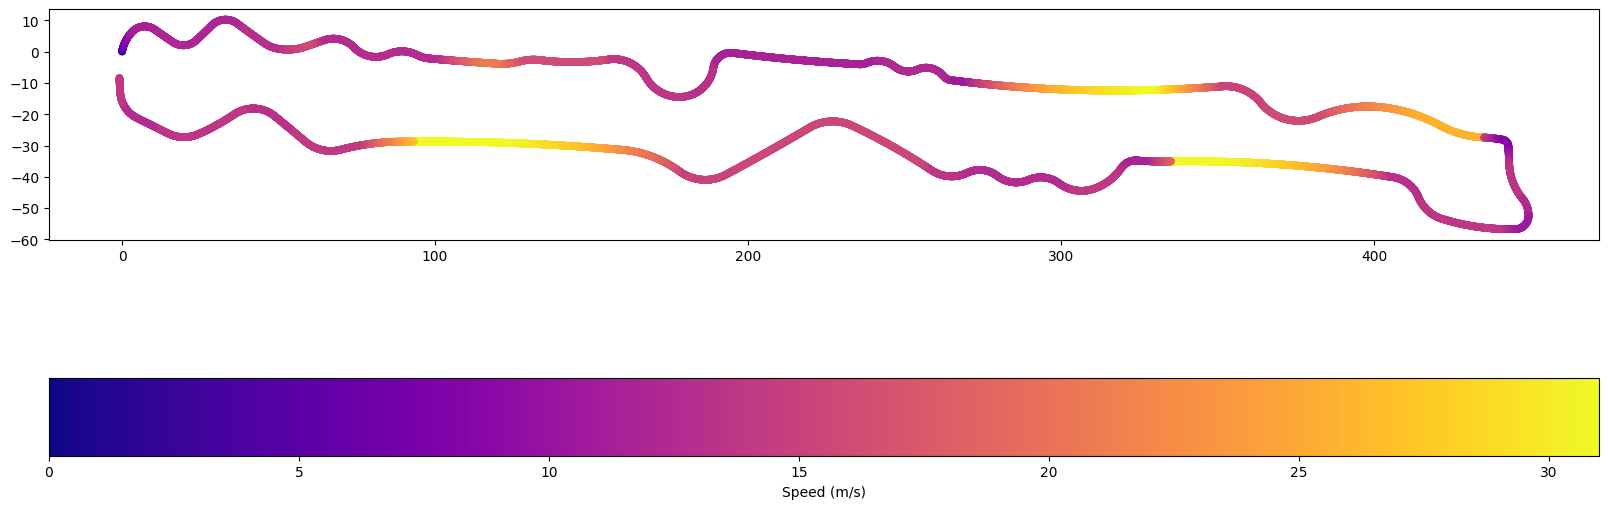

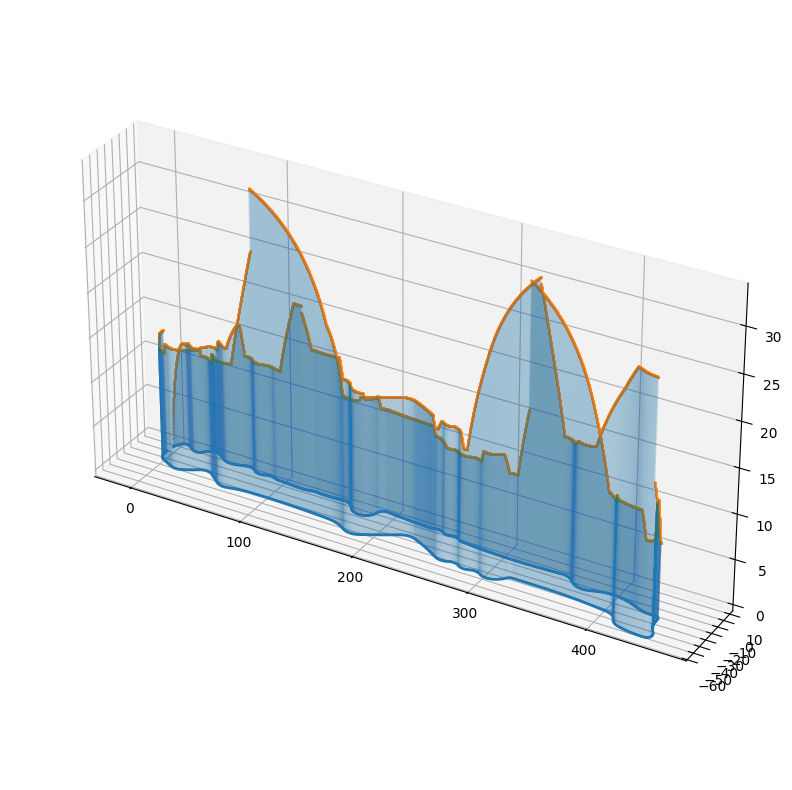

In [4]:
track_vertices = suboptimumg.plotting.track_vis(
    michigan2023_rev9.get_endurance_track(), michigan2023_rev9.get_distance_step(), 80
)

suboptimumg.plotting.map_color(
    track_verts=track_vertices,
    variable=endurance_results.vel_list,
    label="Speed (m/s)",
    norm_min=0,
    norm_max=31,
)
suboptimumg.plotting.map_3d(
    track_verts=track_vertices, variable=endurance_results.vel_list, label="Speed"
)

#### Sweeps

Now we move on to the Sweep functionality, an abstraction built on top of single competition simulations, that allow us to vary one or two parameters, and observe how that affects competition results.

We first define a sweep variable by creating a Python dictionary with four items. "variable" is the name of the variable. To get the correct name, take reference from the names in Car.yaml, and nest parameters using dots. For example, the MOC efficiency should be referred to as "pwrtn.motor.moc_efficiency", and the mass of the car is just "mass".

Observe that plausibility checks are done on the car configurations at both bounds of the sweep. In a 2-variable sweep, four sets of bounds are checked for plausibility.

In [5]:
from suboptimumg.sweep import *

sweep_var_1 = {
    "variable": "mass",
    "min": 200,
    "max": 300,
    "steps": 50,
}
mass_sweep = create_sweeper(
    comp_config=comp_config, default_car_config=car_config, var_1=sweep_var_1
)
mass_results = mass_sweep.sweep()

Running Array Sweeper for 51 competition simulations using 16 processes.


Running simulations: 100%|██████████| 51/51 [00:48<00:00,  1.04sim/s]


Calling .sweep() on the Sweeper class object returns a SweepResults object. We can produce graphs with this SweepResults object. By default, the y-variable in the graph is the total number of points earned in a competition. Optionally, we can also choose to graph other y-variables such as event times and event points by passing arguments like y_var="accel_pts" (indicating Accel event points) or y_var="endurance_t" (indicating time taken to complete Endurance event).

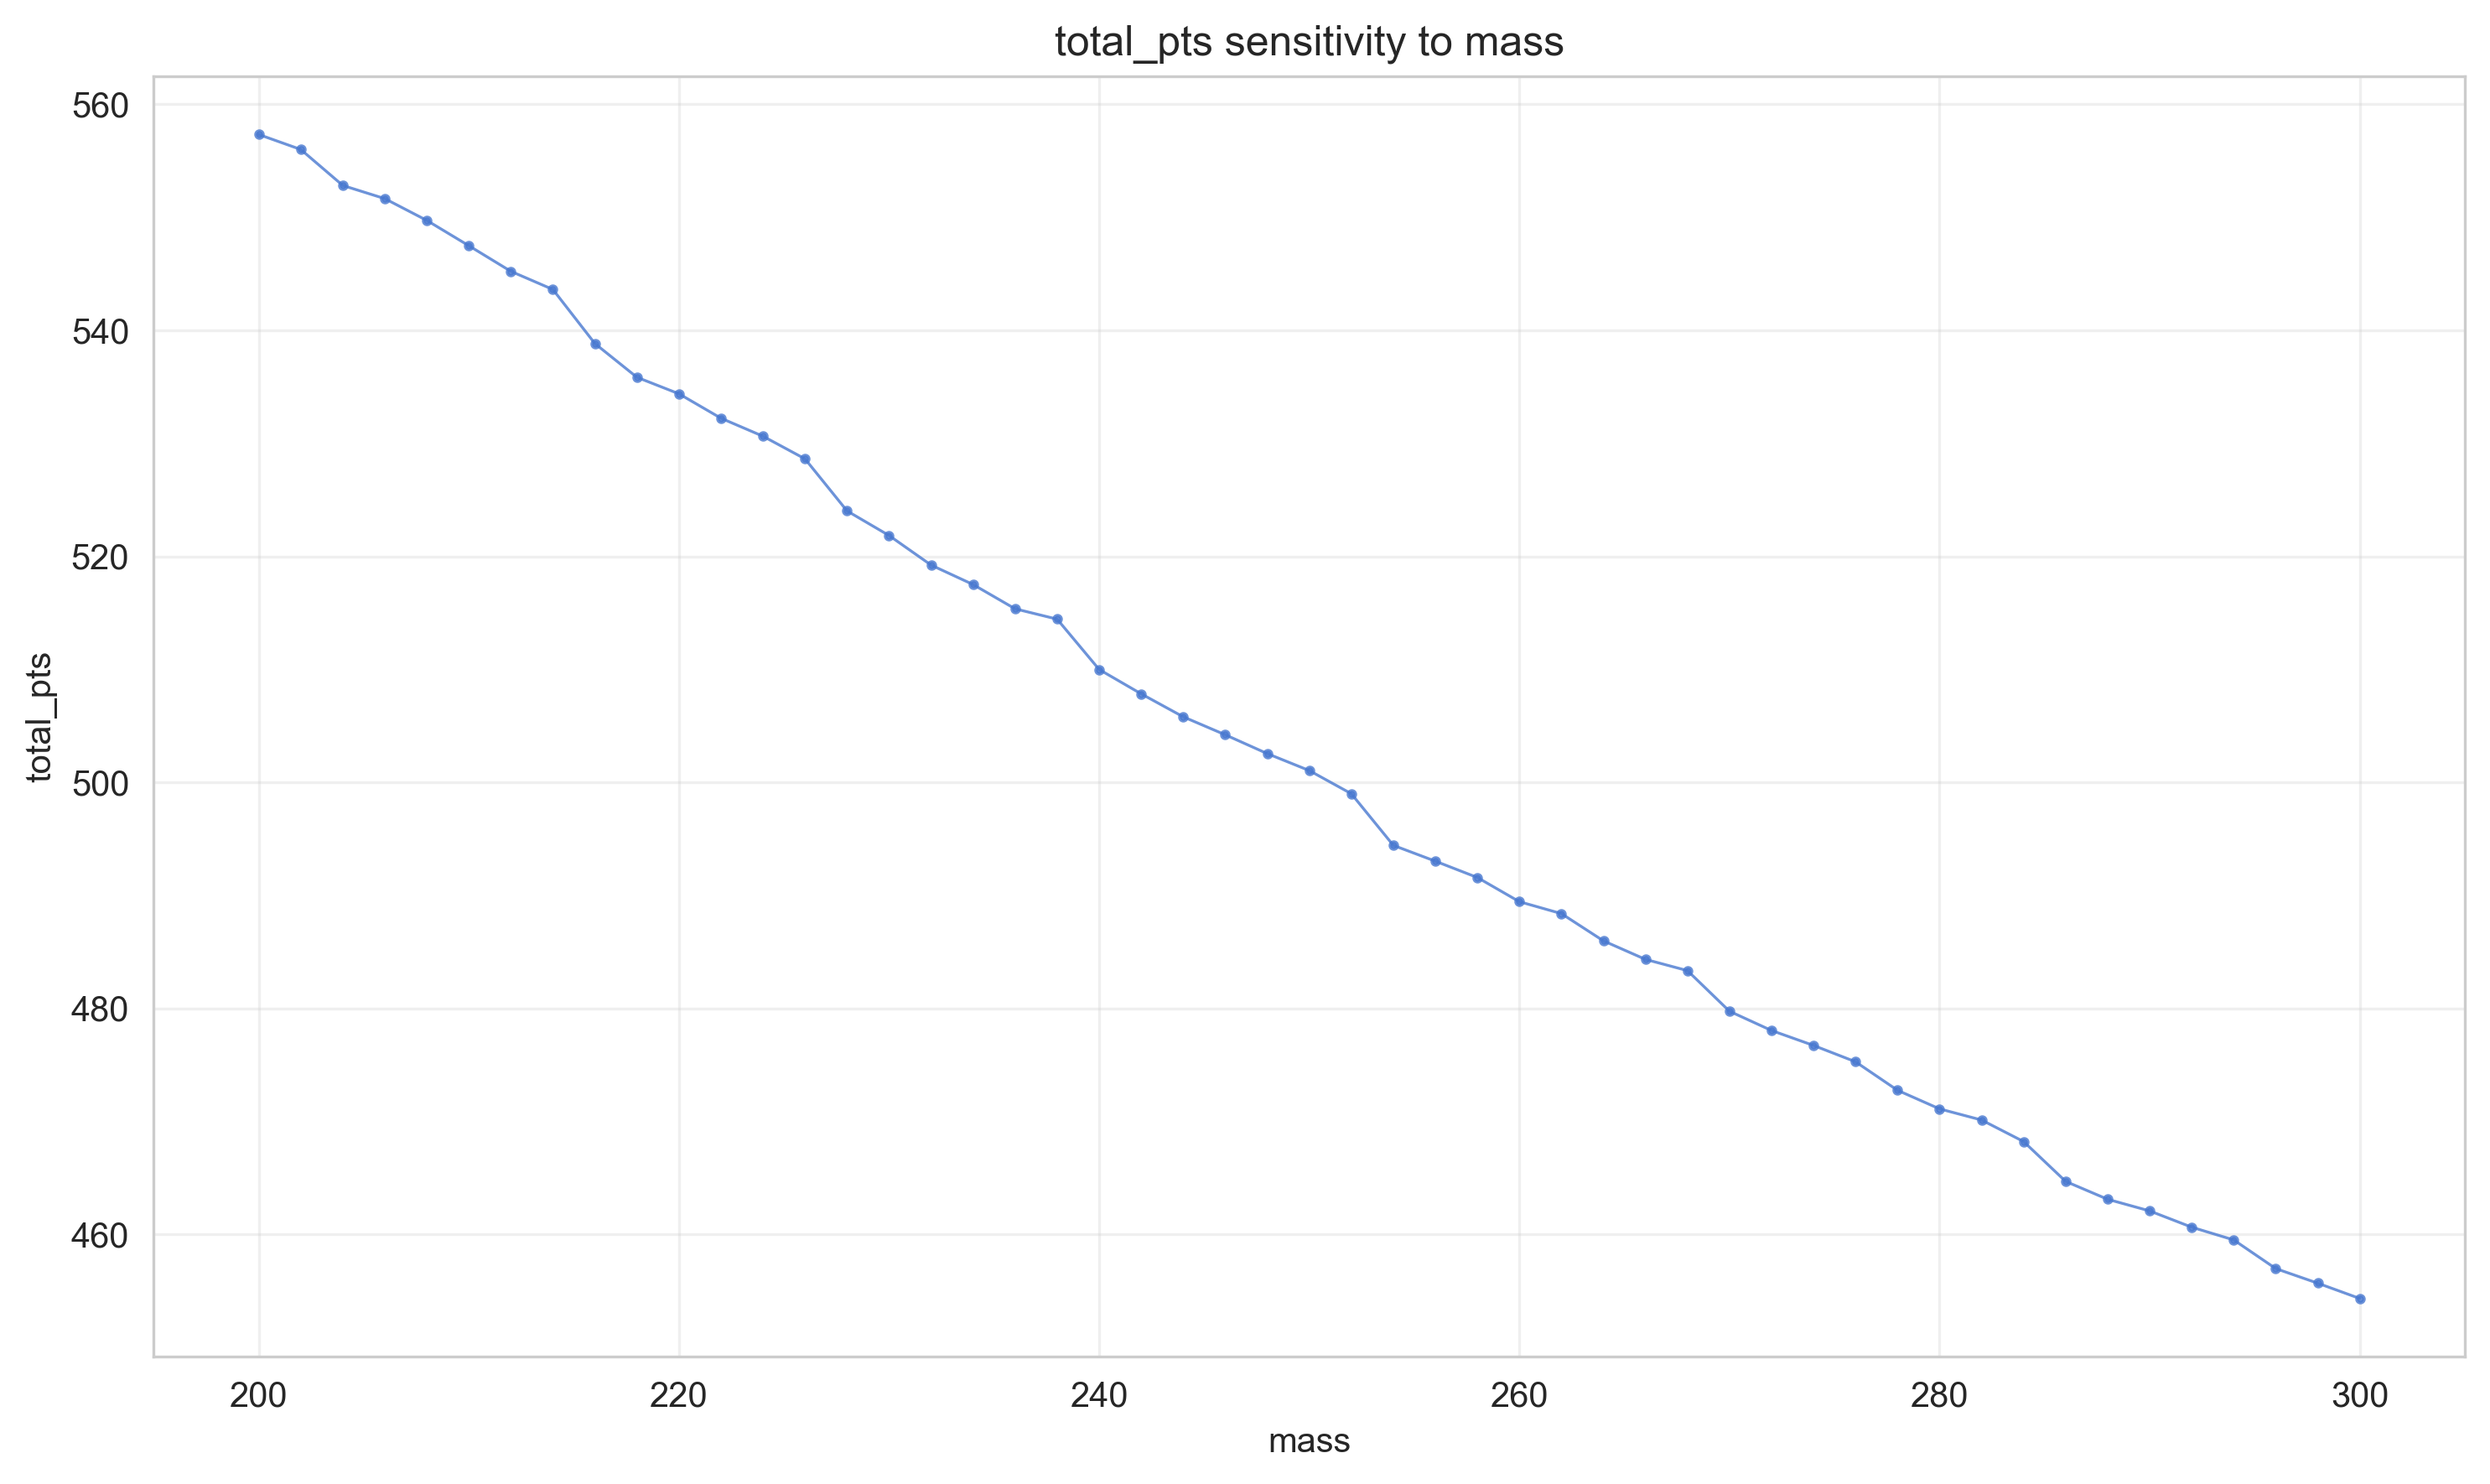

In [6]:
mass_results.plot()

We can also compute interpolated points/times (y_var) and first derivatives for any given x-value within range of the sweep.

In [7]:
print(f"Total points @ mass=264.5: {mass_results.y_at_x(x=264.5)}")
print(
    f"Change in points for every 1kg increase in mass @ mass=264.5: {mass_results.dydx_at_x(x=264.5)}"
)

Total points @ mass=264.5: 485.4174682981252
Change in points for every 1kg increase in mass @ mass=264.5: -1.0353487409702213


The Sweeper class object also supports 2-parameter sweeps.

In [8]:
from suboptimumg.sweep import *

sweep_var_1 = {
    "variable": "aero.cl",
    "min": 2.8,
    "max": 3.8,
    "steps": 25,
}

sweep_var_2 = {
    "variable": "aero.cd",
    "min": 1.0,
    "max": 2.0,
    "steps": 25,
}

aero_sweep = create_sweeper(
    comp_config=comp_config,
    default_car_config=car_config,
    var_1=sweep_var_1,
    var_2=sweep_var_2,
)
aero_results = aero_sweep.sweep()

Running Grid Sweep for 676 competition simulations using 16 processes.


Running simulations: 100%|██████████| 676/676 [12:03<00:00,  1.07s/sim]


For 2-parameter sweep results, we can likewise compute interpolated points/times (z_var) and partial derivatives at any given pair of parameters within the sweep range.

In [9]:
# x refers to var_1 (aero.cl in this case) and y refers to var_2 (aero.cd in this case)
print(f"Total points @ cl=1.205, cd=2.675: {aero_results.z_at_xy(x=3.55, y=1.65)}")
print(
    f"Additional point gain for every 1.0 increase in cl @ cl=3.55, cd=1.65: {aero_results.dzdx_at_xy(x=3.55, y=1.65)}"
)
print(
    f"Additional point gain for every 1.0 increase in cd @ cl=3.55, cd=1.65: {aero_results.dzdy_at_xy(x=3.55, y=1.65)}"
)

Total points @ cl=1.205, cd=2.675: 452.55334570932223
Additional point gain for every 1.0 increase in cl @ cl=3.55, cd=1.65: 23.06769243659801
Additional point gain for every 1.0 increase in cd @ cl=3.55, cd=1.65: -19.237022296692885


For 2-parameter sweep results, we have a choice between two types of graphs to represent the data. Call either .plot_contour() or .plot_surface(). Again, the target variable is by default total points, but can be controlled by passing an argument like z_var="endurance_pts".

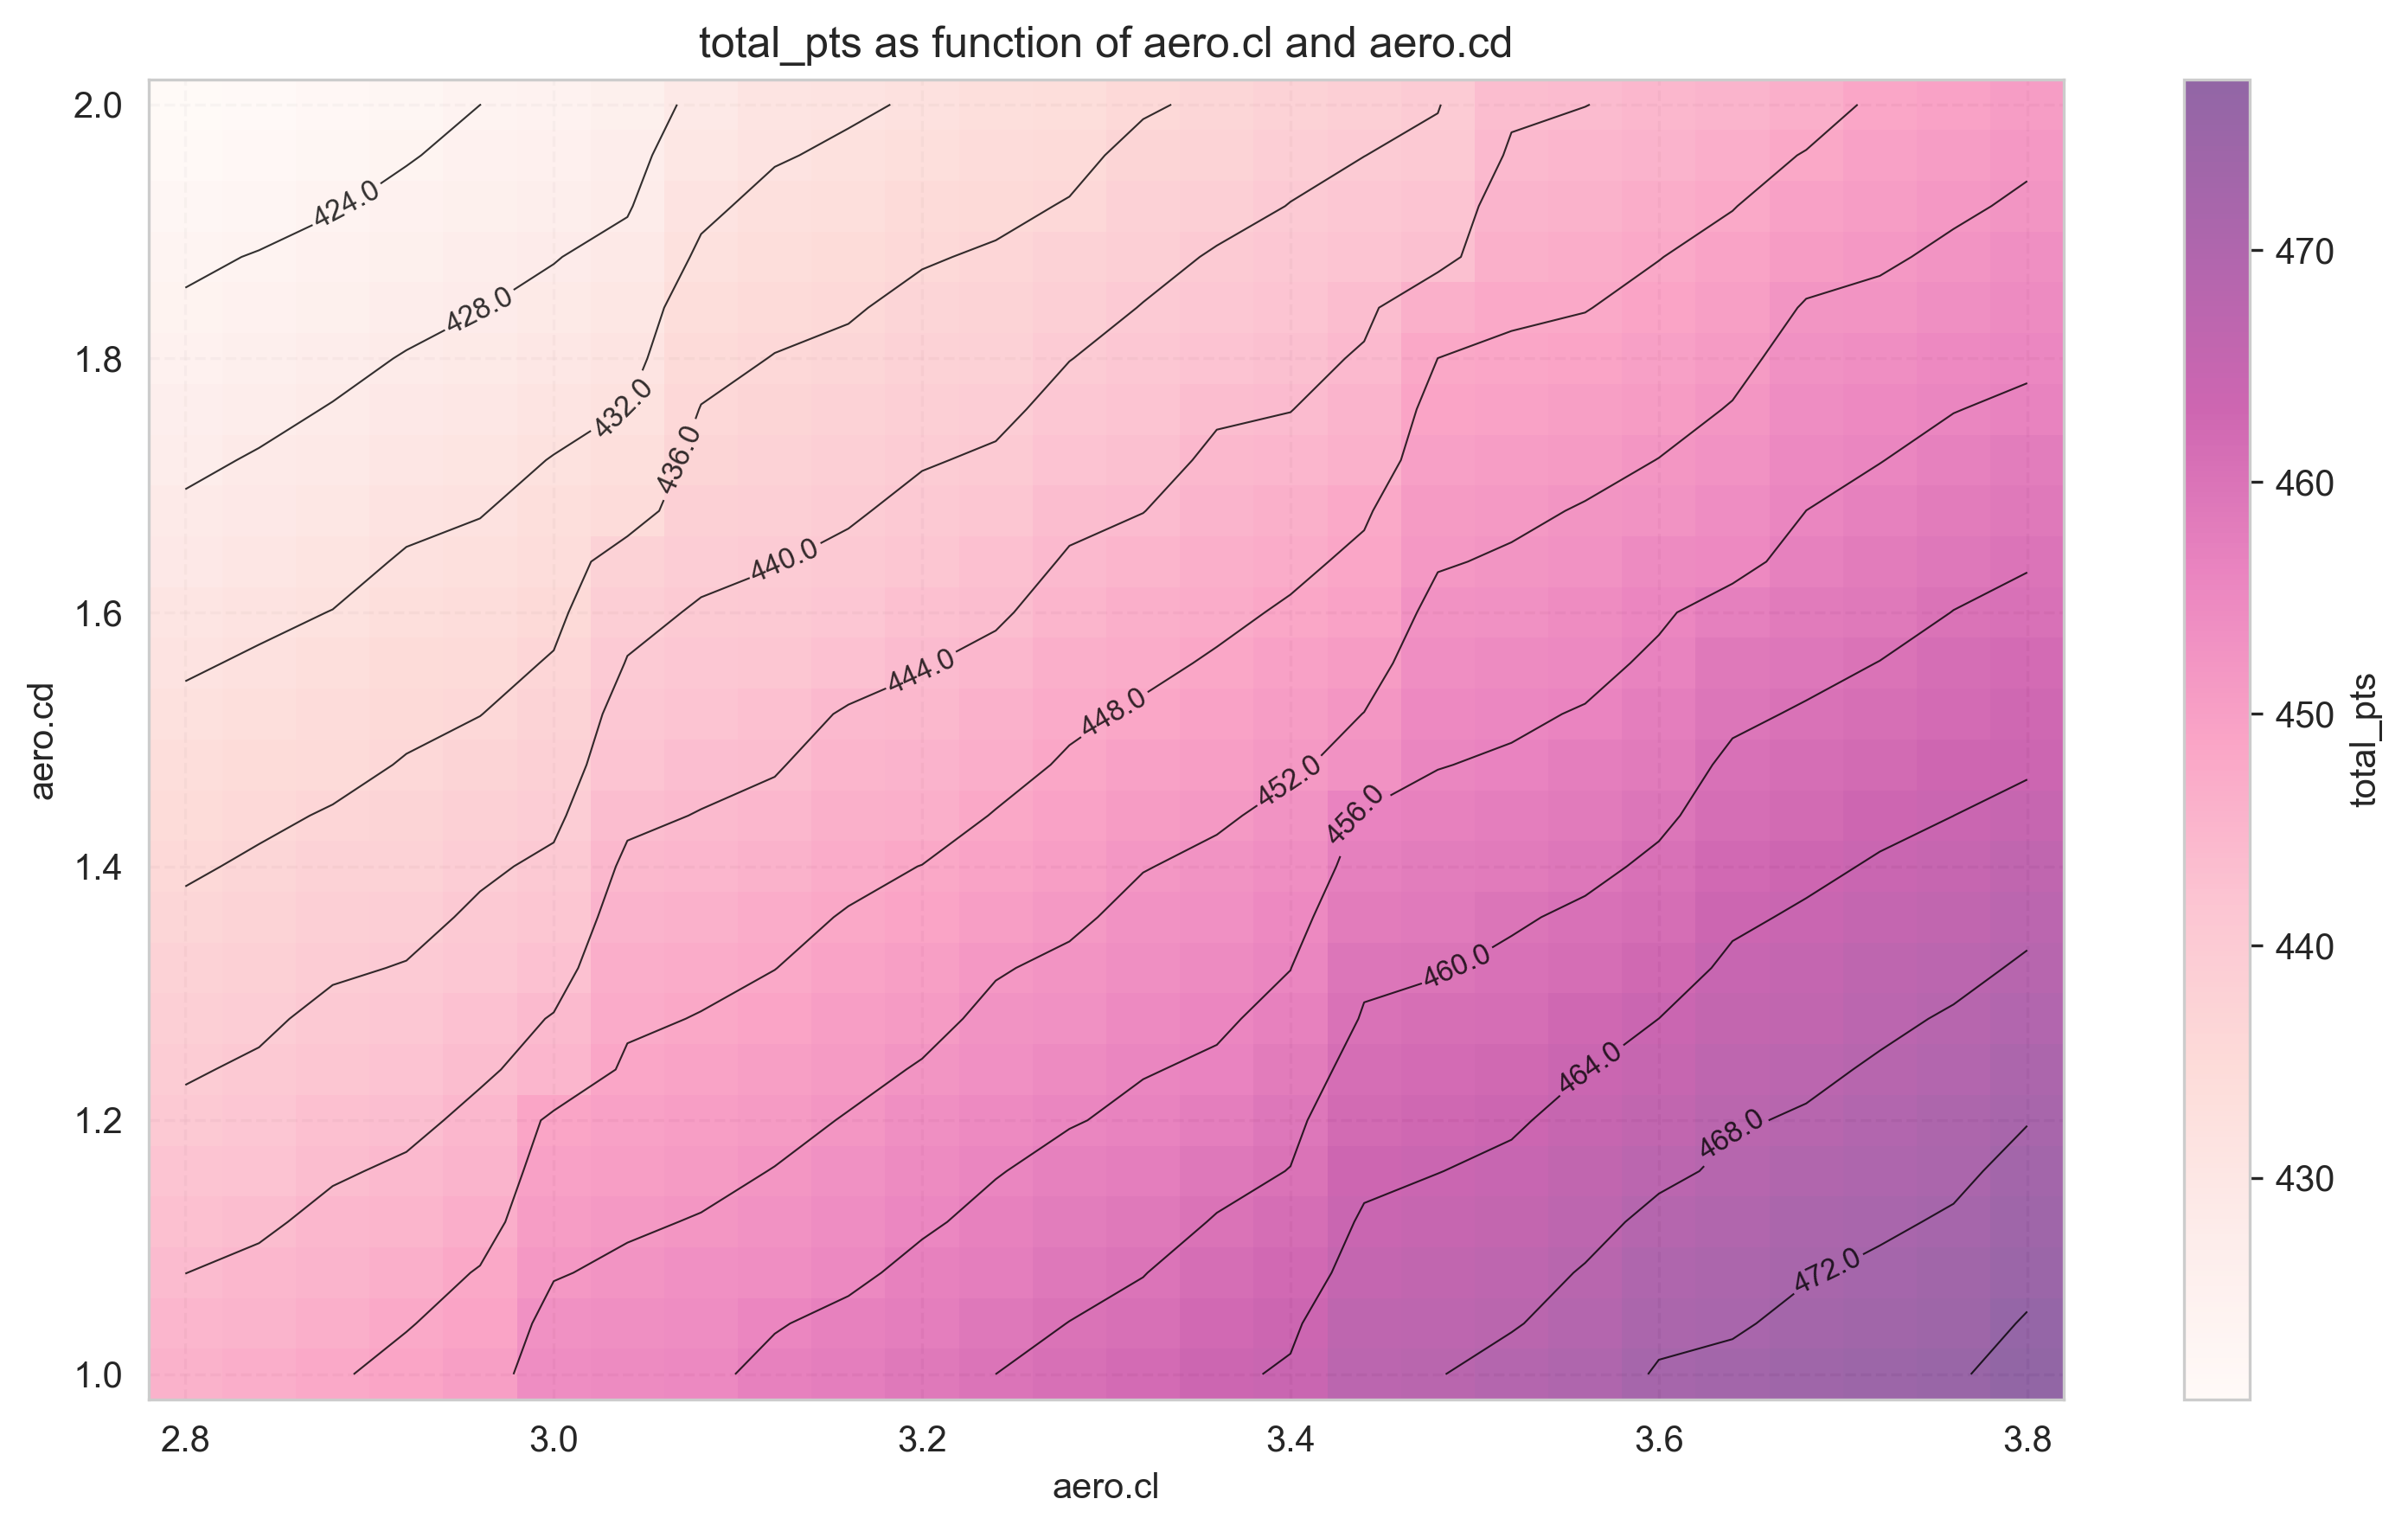

In [10]:
aero_results.plot_contour()

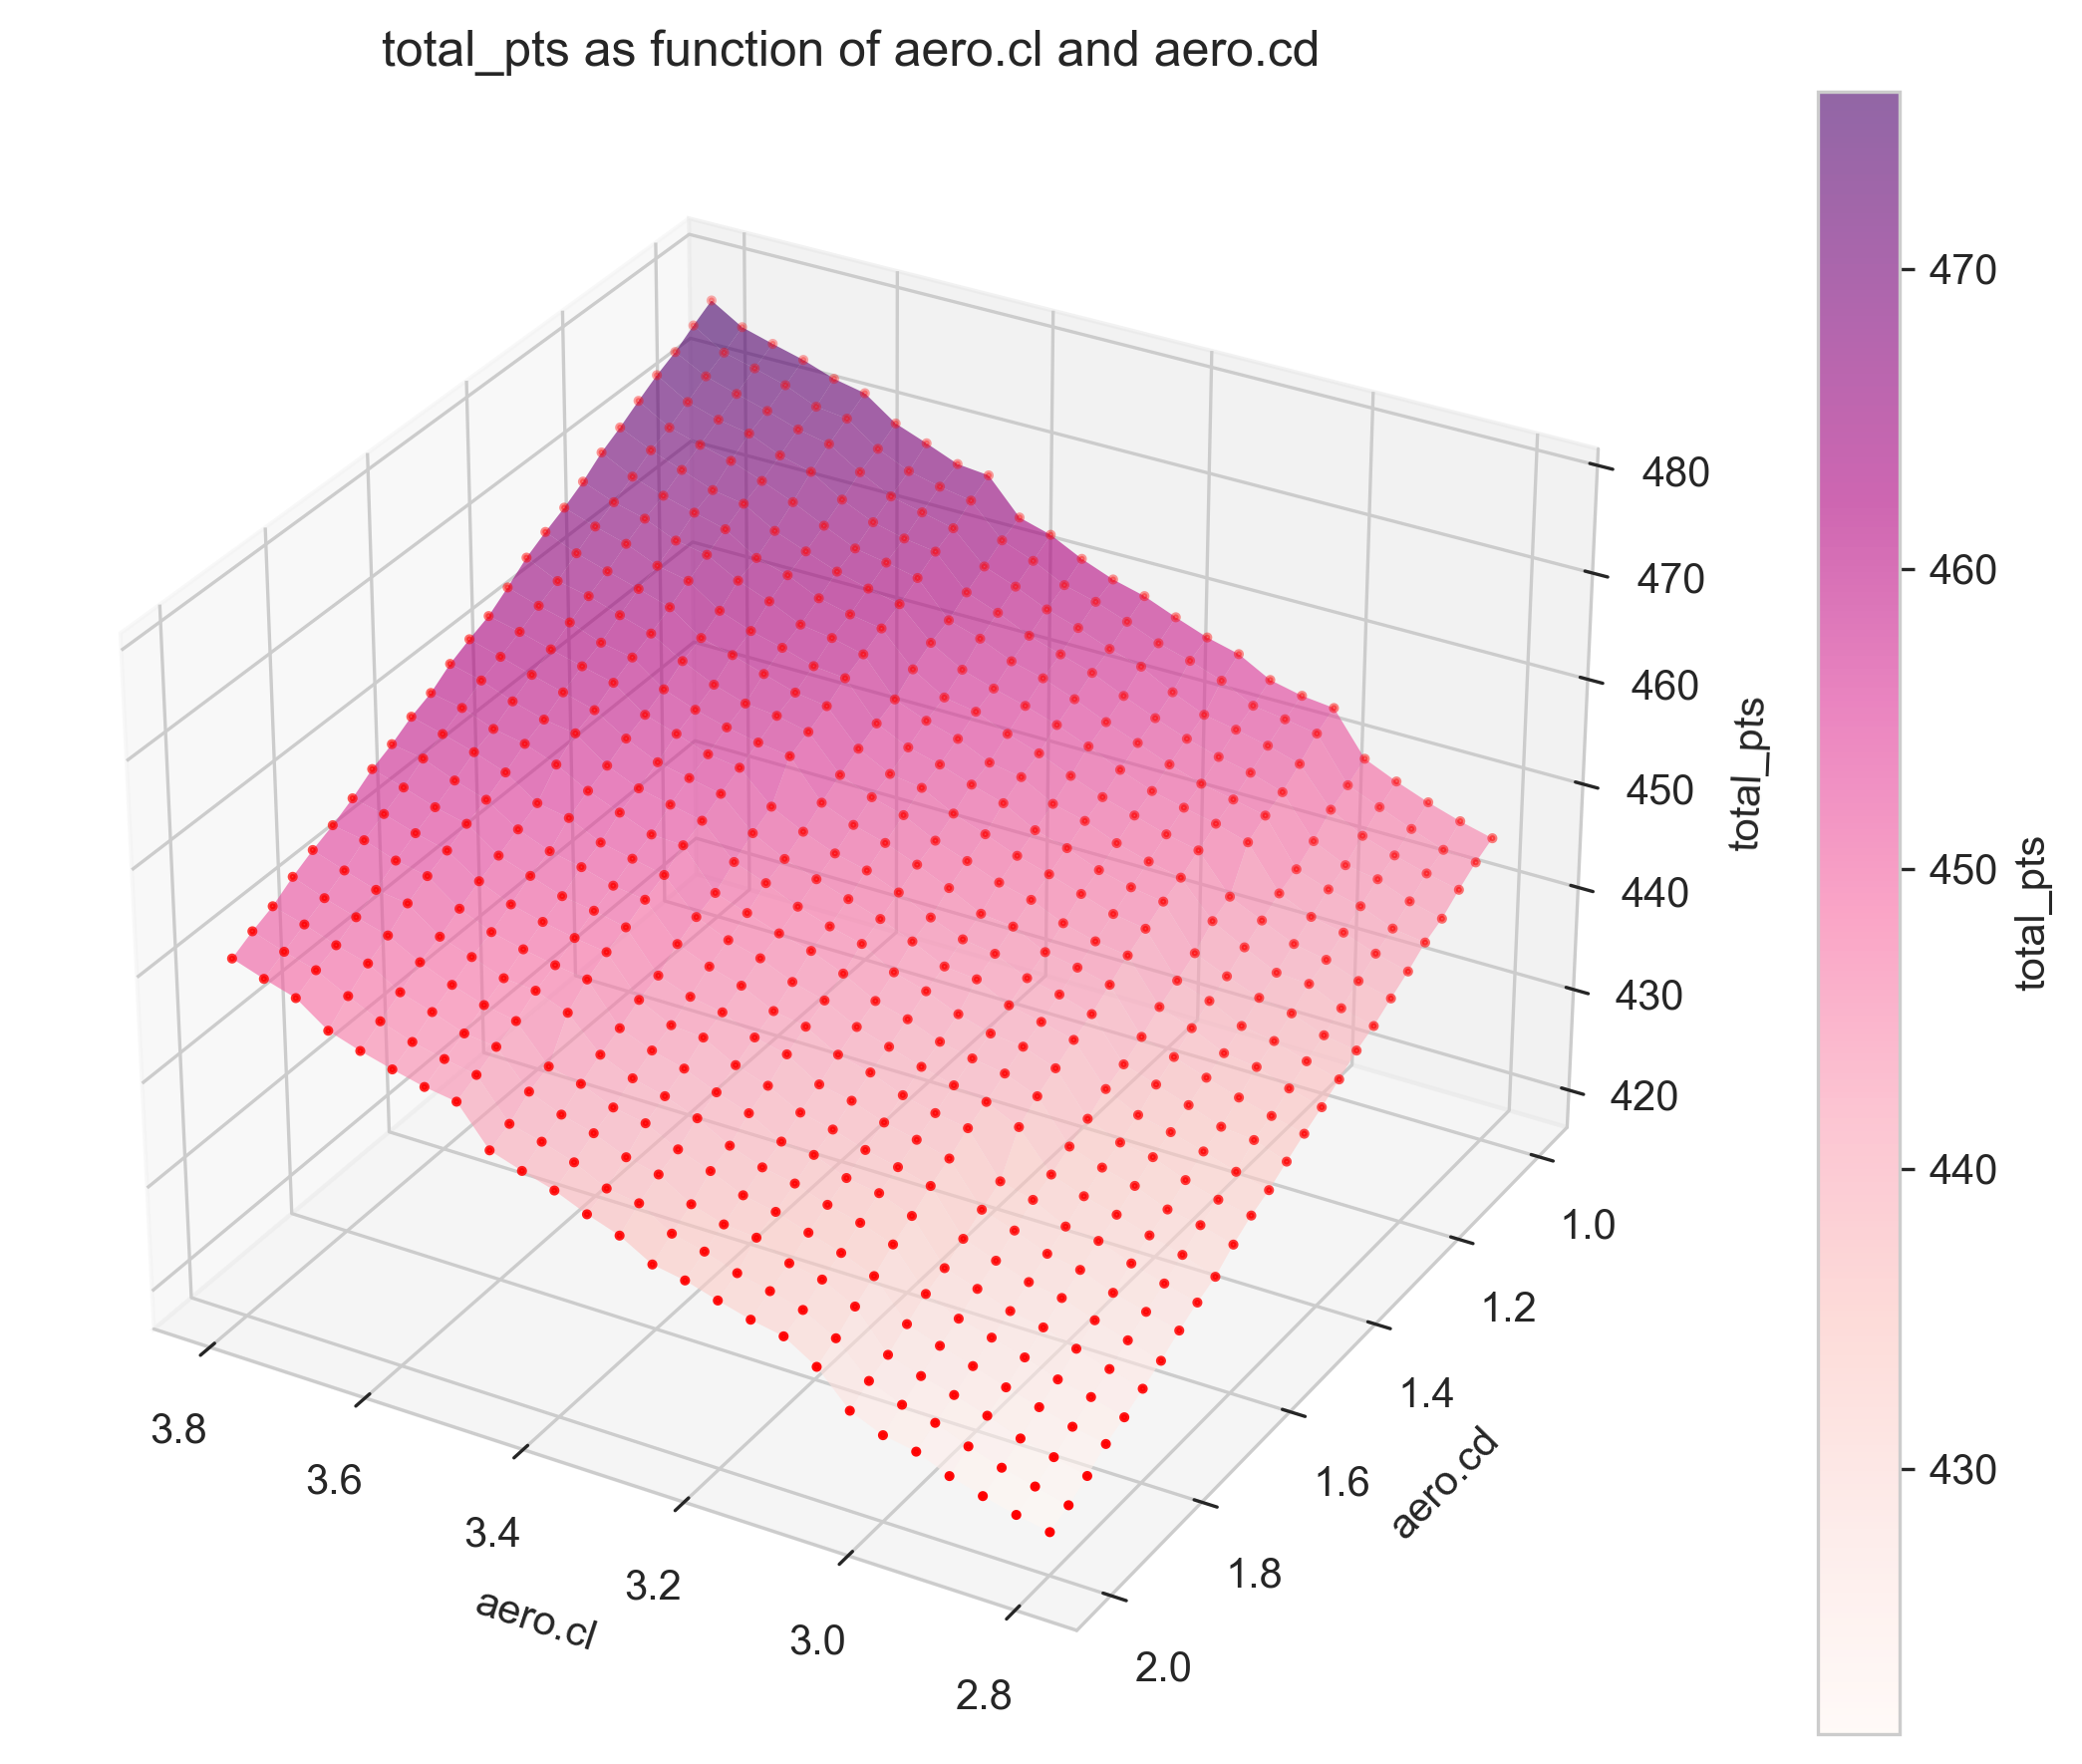

In [11]:
aero_results.plot_surface(view_angle=120)

We can also do a special sweep to analyze battery pack capacity. Here, we provide the min, max, and step count of battery pack capacity limit (units of kWh). We can optionally provide a second parameter to sweep across.

In [12]:
from suboptimumg.sweep import CapacityLimitSweeper1D

cap_limit_sweep = CapacityLimitSweeper1D(
    comp_config=comp_config,
    default_car_config=car_config,
    min_energy=2.5,
    max_energy=8.5,
    energy_steps=24,
)
cap_limit_results = cap_limit_sweep.sweep()

Running Capacity Sweep for 25 competition simulations using 16 processes.


Running simulations: 100%|██████████| 25/25 [01:18<00:00,  3.14s/sim]


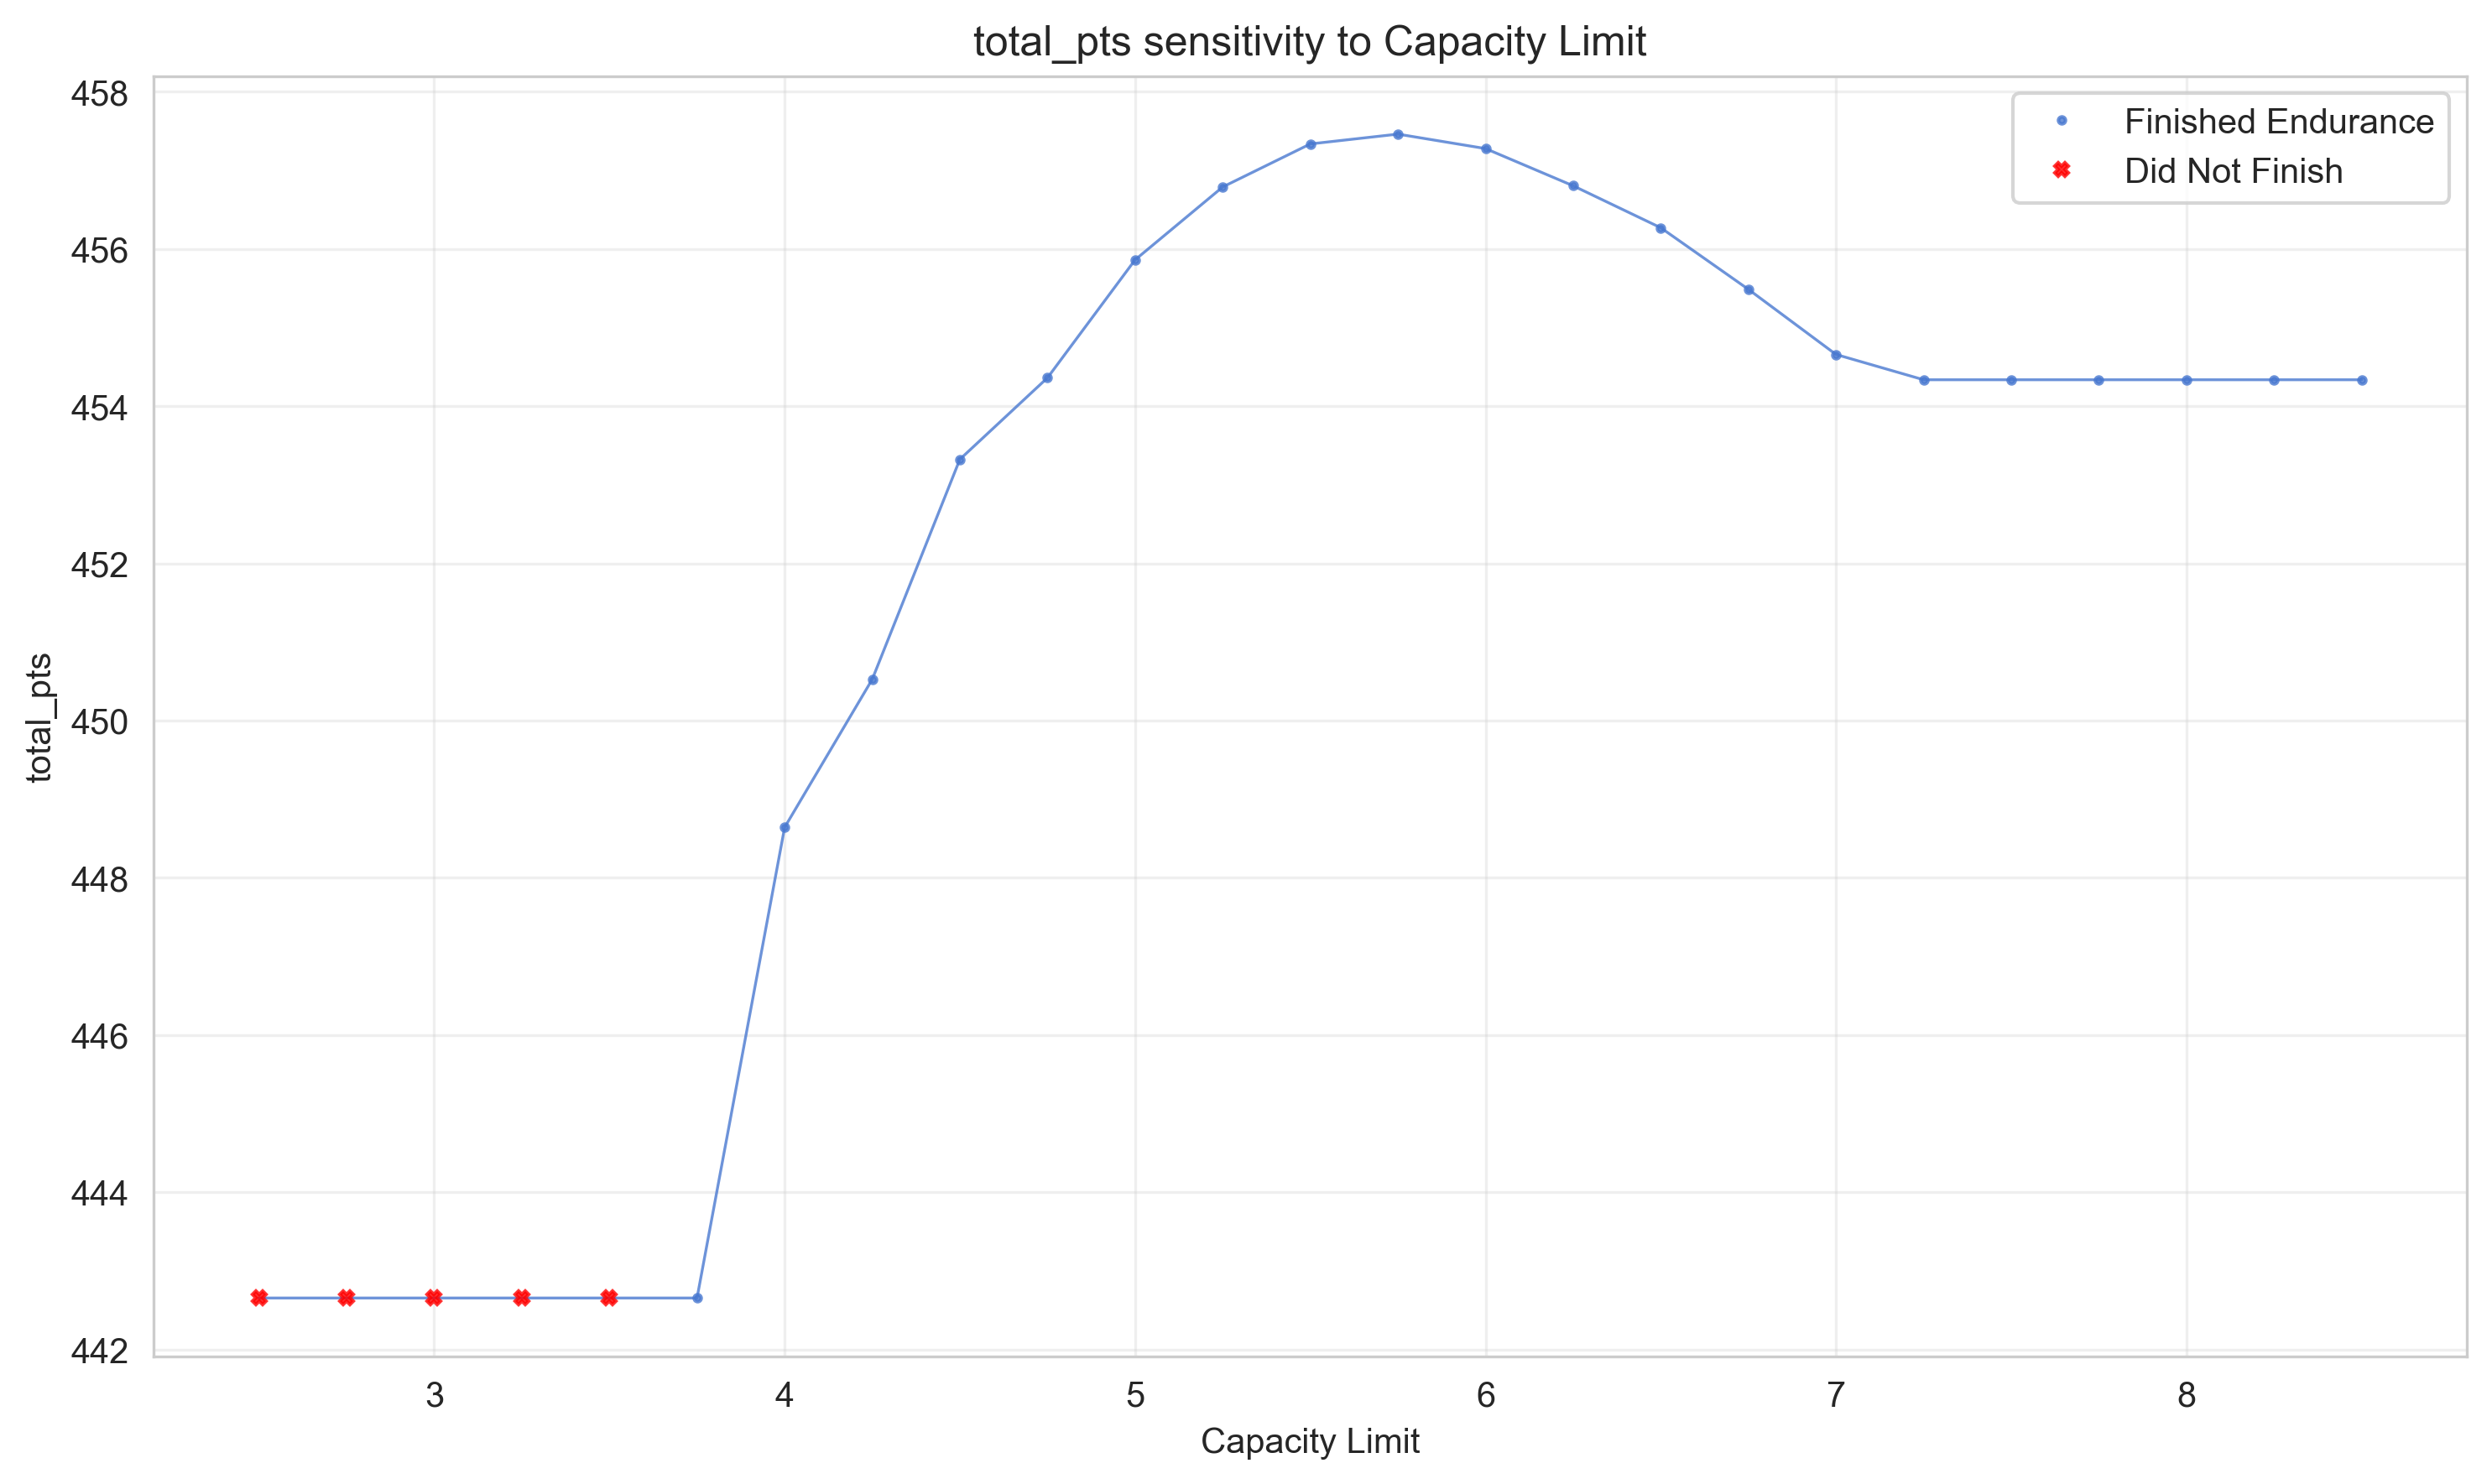

In [13]:
cap_limit_results.plot()

In [14]:
from suboptimumg.sweep import CapacityLimitSweeper2D

sweep_var = {
    "variable": "mass",
    "min": 250,
    "max": 300,
    "steps": 10,
}

cap_limit_sweep = CapacityLimitSweeper2D(
    comp_config=comp_config,
    default_car_config=car_config,
    min_energy=2.5,
    max_energy=8.5,
    energy_steps=12,
    var=sweep_var,
)
cap_limit_results = cap_limit_sweep.sweep()

Running Capacity Grid Sweep for 143 competition simulations using 16 processes.


Running simulations: 100%|██████████| 143/143 [08:05<00:00,  3.40s/sim]


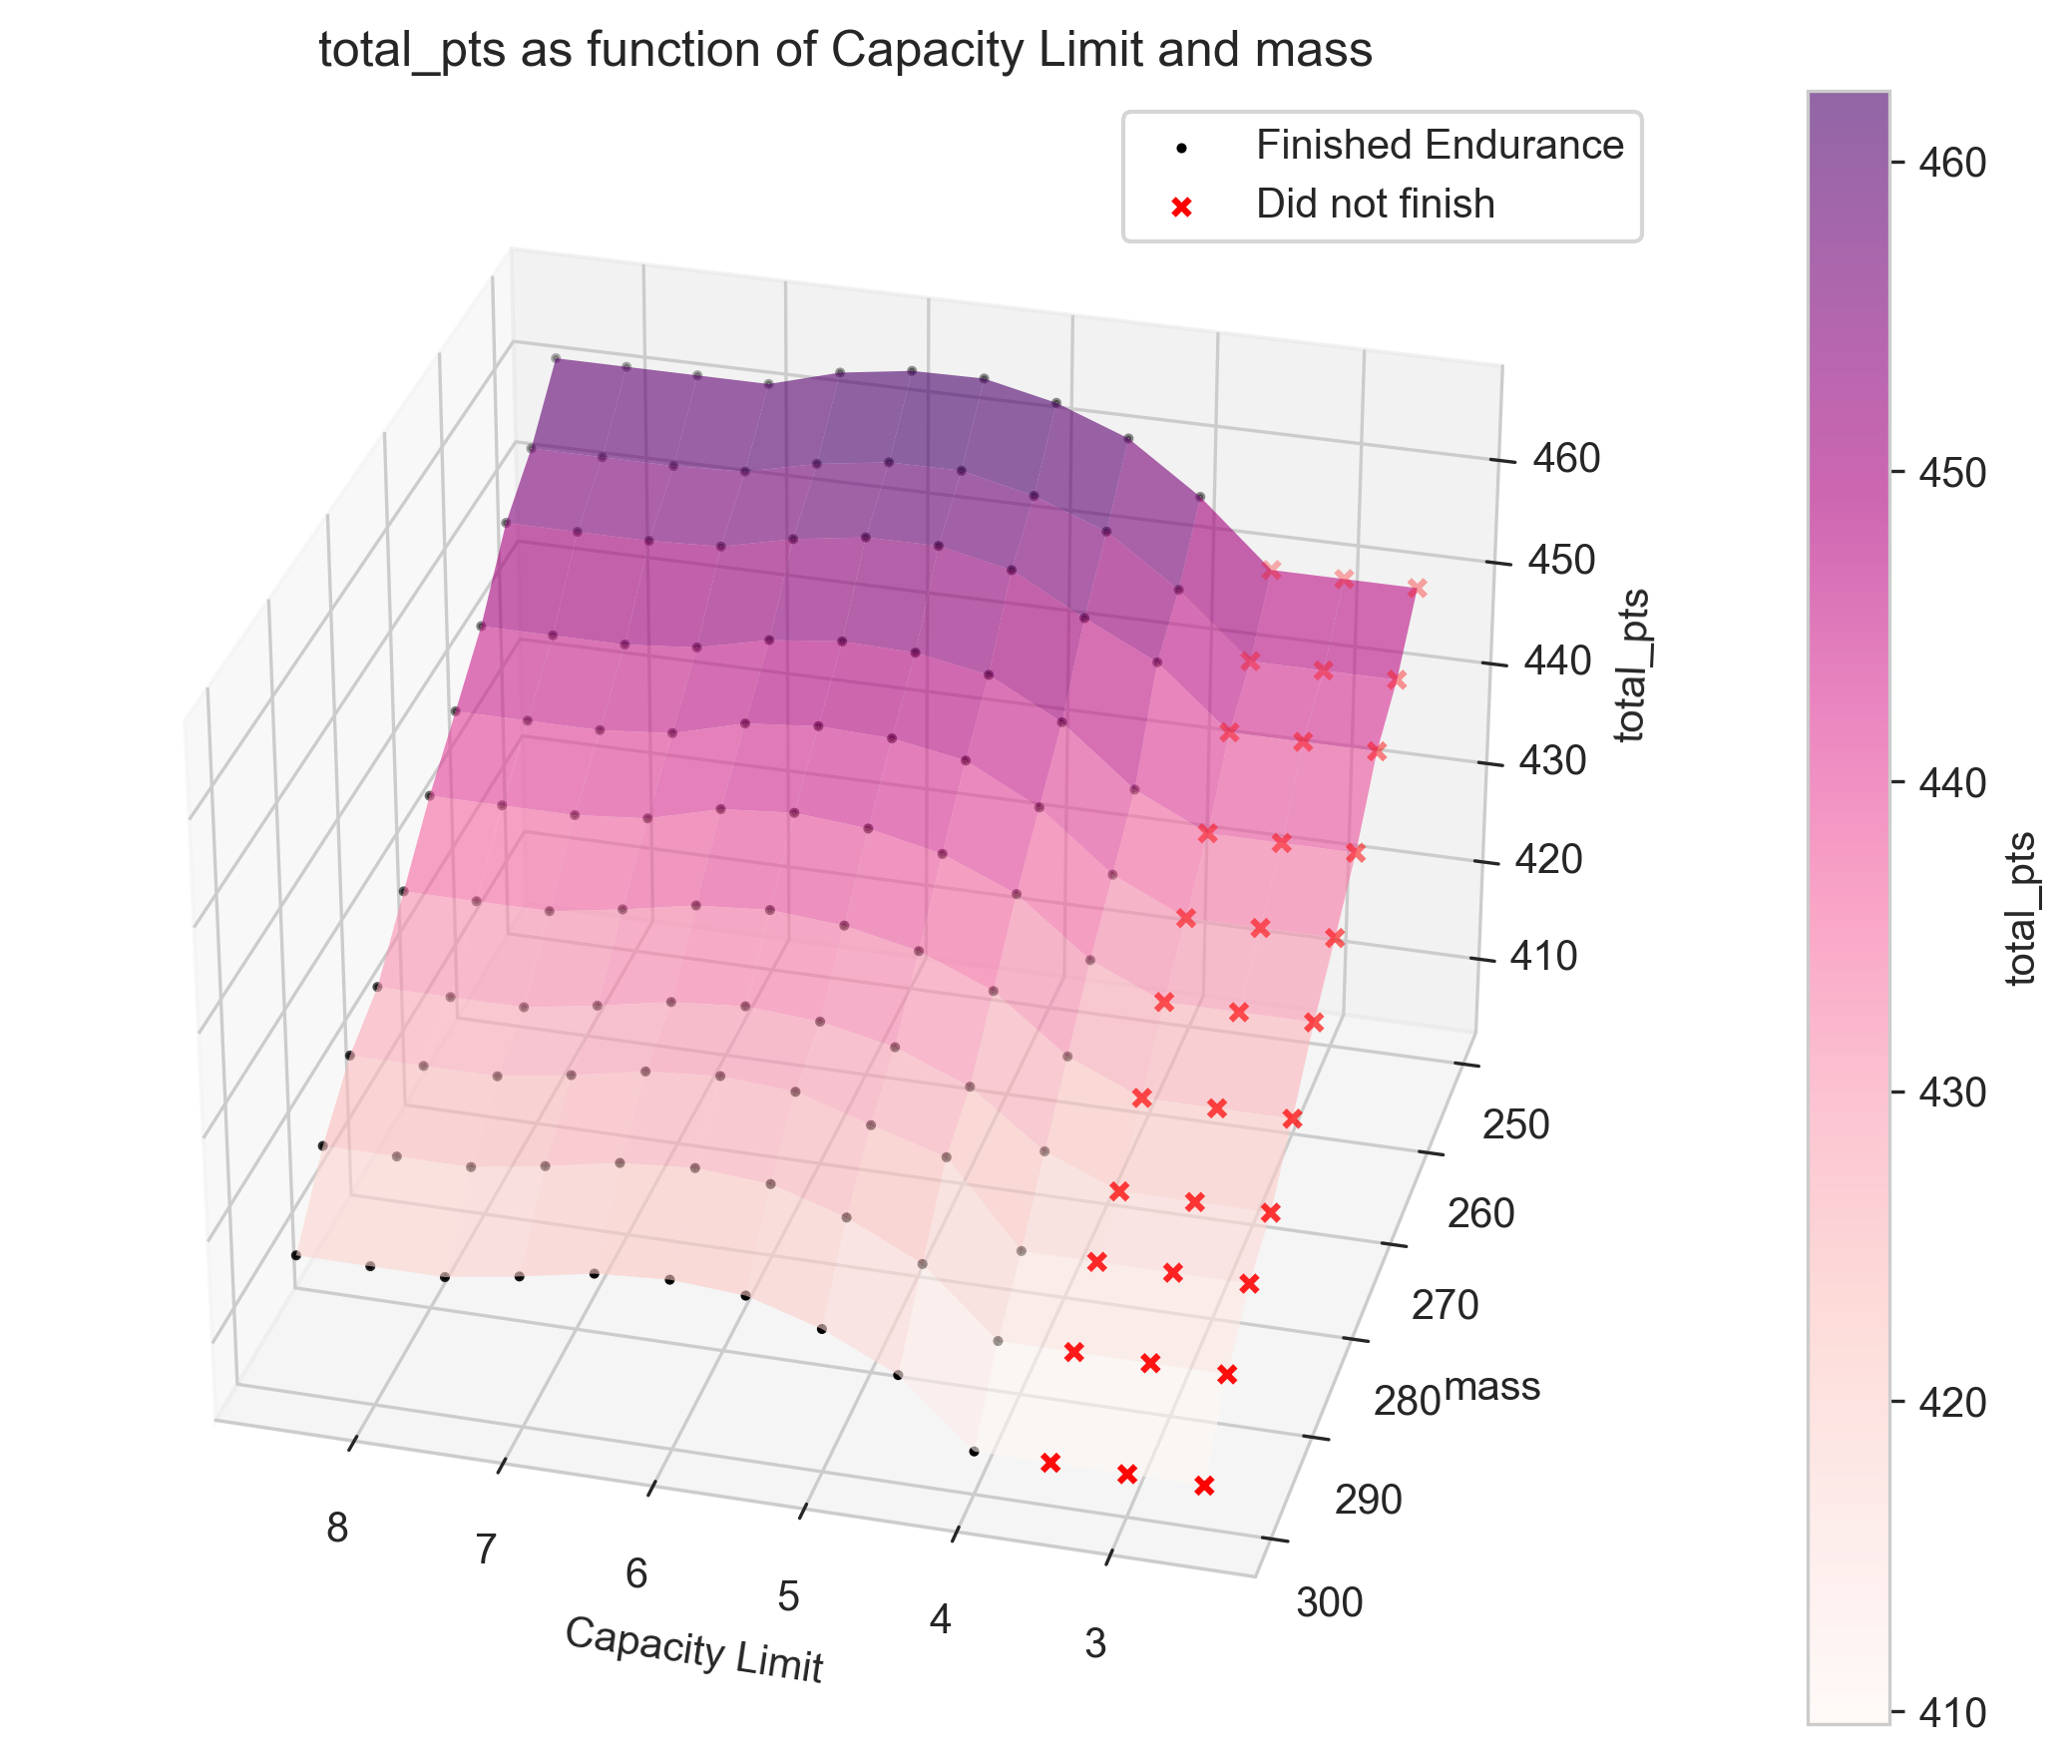

In [15]:
cap_limit_results.plot_surface(view_angle=105)

We can do a full vehicle parameter sweep by using the ArraySweeper class

This takes in the following parameters:
- comp_config: competition-wide parameters
- default_car_config: default car parameters
- var_list: list of variables to sweep e.g. ["mass", "pwrtn.motor.moc_efficiency"]
- var_percent_step_list: list of percent steps to sweep default is:
    [-0.1, -0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08, 0.1]

This is currently a WIP and will not work as expected.

In [16]:
from suboptimumg.sweep import ArraySweeper

arr_sweep_params = [
    "mass",
    "w_distr_b",
    "cg_h",
    "wb",
    "front_track",
    "rear_track",
    "aero.cl",
    "aero.cd",
    "aero.front_area",
    "aero.cop",
    "pwrtn.motor.pow_lim",
    "pwrtn.ratio",
    "pwrtn.regen_percent",
    "rolling_coeff",
]
arr_sweep = ArraySweeper(
    comp_config=comp_config, default_car_config=car_config, var_list=arr_sweep_params
)
arr_sweep_results = arr_sweep.sweep(verbose=True)

Running Array Sweeper for 154 competition simulations using 16 processes.


Running simulations: 100%|██████████| 154/154 [02:39<00:00,  1.04s/sim]


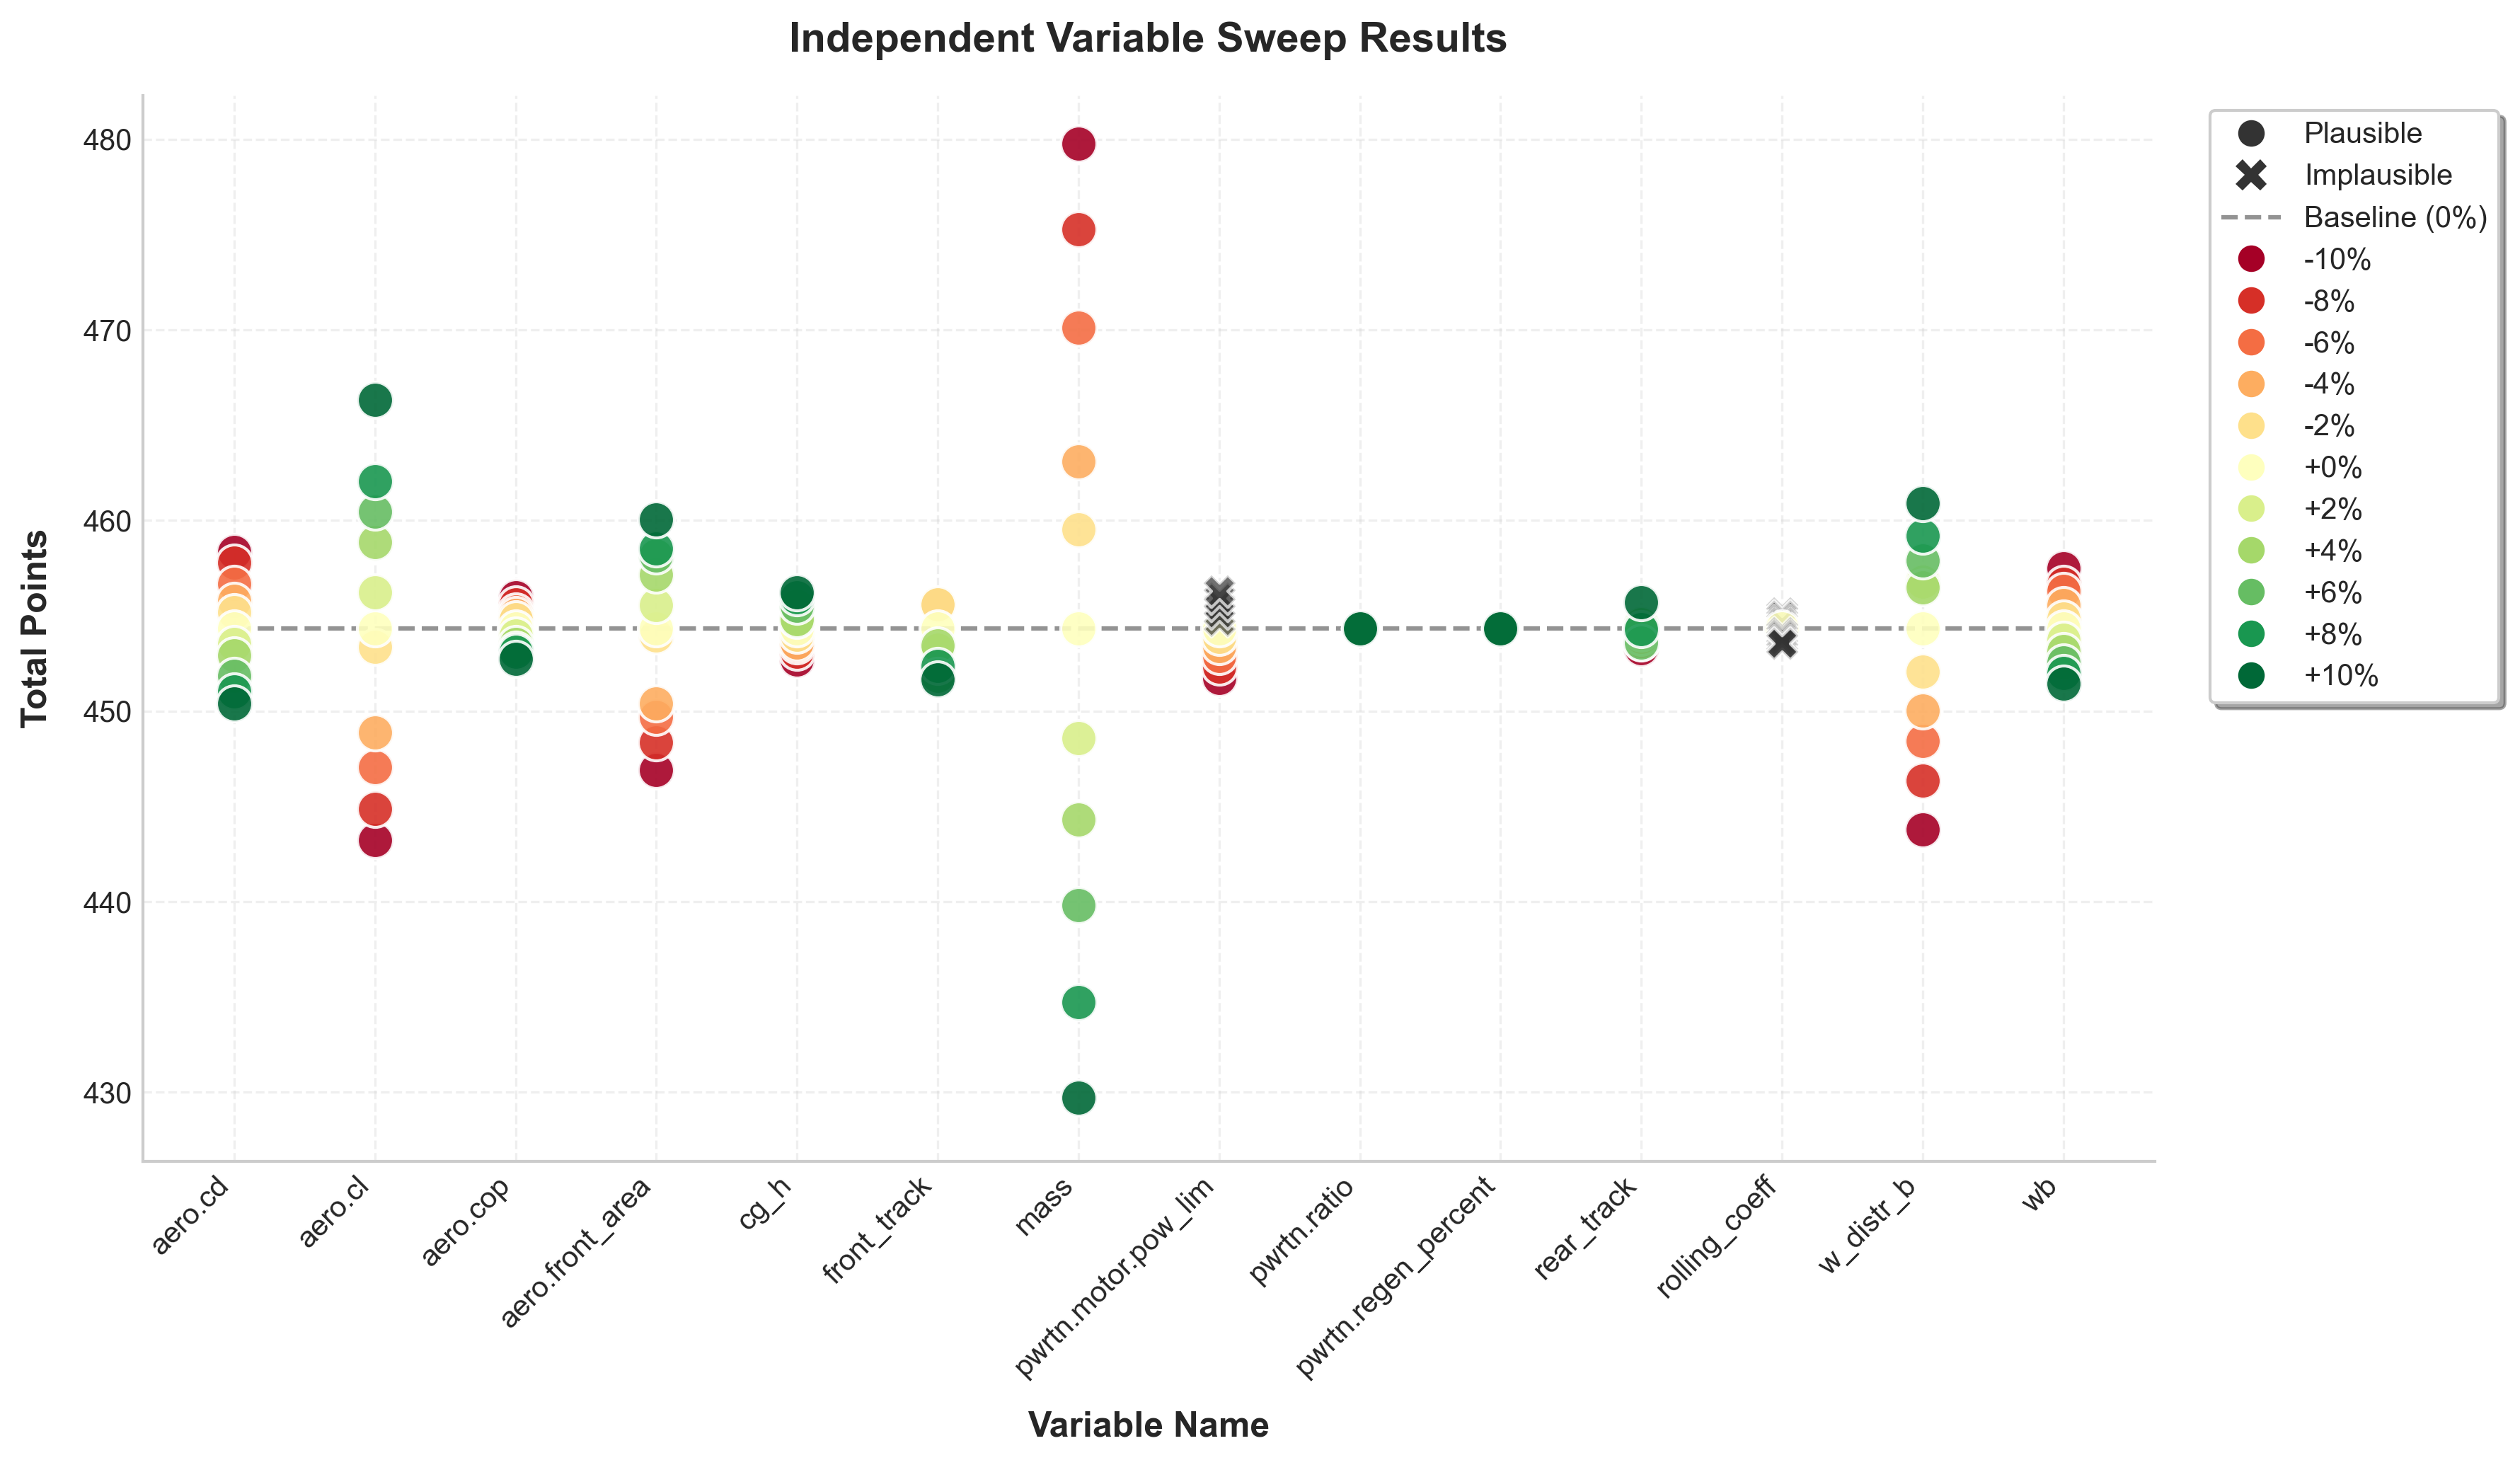

In [17]:
arr_sweep_results.plot()